## Julia on Colaboratory ##

In this code, our capsnet model is trained on Mnist data with number of iterations equals to 1 and 3. Also with the same number of iteratons reconstruction used as a regularization method.

** First two cells are used for google colab


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
# Installation cell
%%shell
if ! command -v julia 2>&1 > /dev/null
then
    wget 'https://julialang-s3.julialang.org/bin/linux/x64/1.3/julia-1.3.1-linux-x86_64.tar.gz' \
        -O /tmp/julia.tar.gz
    tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
    rm /tmp/julia.tar.gz
fi
julia -e 'using Pkg; pkg"add Plots; add PyPlot; add IJulia; add Knet; add MAT;"'
julia -e 'using Pkg; pkg"build Knet;"'

In [7]:
using Knet
# Test if Knet is using gpu
Knet.gpu()


0

In [ ]:
# Setup display width, load packages, import symbols
ENV["COLUMNS"]=72
using Pkg; for p in
 ("Knet","IterTools","Plots","PyPlot","IJulia","MAT"); haskey(Pkg.installed(),p) || Pkg.add(p); end

using Base.Iterators: flatten
using IterTools: ncycle, takenth
using Statistics: mean
using Knet: Knet, conv4, pool, mat, KnetArray, nll, zeroone, progress, sgd, param, param0, dropout, relu, Data, gpu
using PyPlot
using Plots
using MAT
IJulia.set_max_stdio(1<<25);

# User should define this options below


In [ ]:
# User should define this options 
get_files_from_drive = false; # I used it for using with colab and google drive
use_reconstruction_loss = true #true or false
number_of_iteration = 3;  # Saved datas only available for 1 and 3. Any integer more than 1 can be selected but training from scratch will be required.
number_of_epochs = 10;

In [ ]:
# Initializing parameters

batch_size = 50;
height_width_of_Image = 28
conv_layer_channel_number = 256
dimension_of_PrimaryCaps_vector = 8
number_of_PrimaryCaps = 1152
height_width_of_PrimaryCaps = 6
number_of_class = 10
dimension_of_DigitCaps = 16
total_size_of_Digitcaps = dimension_of_DigitCaps*number_of_class;
first_conv_layer_size = 9
first_conv_layer_stride = 1
second_conv_layer_size = 9
second_conv_layer_stride = 2
decoder_dense_layer_1_size = 512
decoder_dense_layer_2_size = 1024
decoder_dense_layer_3_size = height_width_of_Image*height_width_of_Image;
#Parameters used in margin loss function
m_plus = 0.9;
m_minus = 0.1;
lambda = 0.5;
r_loss = 0.0005;

In [ ]:
include(Knet.dir("data","mnist.jl"))  # Load data
dtrn,dtst = mnistdata(batchsize=batch_size);   

In [51]:
# Squashing function definition
function squashing(s; axis=2)
  norm2 = sum(abs2.(s),dims=axis);
  scaled = s./sqrt.(norm2);
  result = (norm2./(norm2.+1)).*scaled;
end

squashing (generic function with 1 method)

In [52]:
#Defining masking function with returns only one column for correct prediction in digit caps
function masking(v,yh)
  expander = convert(KnetArray{Float32},ones(10,50,16));
  masker = permutedims(yh.*expander,(1,3,2));
  masked = v.*masker;
end

masking (generic function with 1 method)

In [53]:
 # 1D array to one hot vector function or if input is 2D with probabilities it gives one hot vector
 function to_onehot(y;target_type = KnetArray{Float32} ,num_class = 10)
  if length(size(y)) == 1 
          length_y = length(y)
          onehot = convert(target_type,zeros(num_class, length_y))
          for i = 1 : length_y
            onehot[y[i],i]=1;
          end
          result = onehot
    elseif length(size(y)) == 2
          num_class = size(y,1)
          length_y= size(y,2)  
          onehot = convert(target_type,zeros(num_class, length_y))
          maxes = maximum(y, dims = 1)
          for j=1:length_y
              for i=1:num_class
                  if maxes[j]==y[i,j]
                  onehot[i,j] = 1
                  end
             end
          end
          result = onehot
    end
  return result
  end

to_onehot (generic function with 1 method)

In [54]:
# Calculating loss and error on data set with using W array 
function calculate_loss_and_error(trained_ws,data,model;numIter=3)
  l_ws = length(trained_ws)
  error_in_epochs = Float64[]
  loss_in_epochs = Float64[]

  for i = 1:l_ws
    current_w = trained_ws[i];
    loss_network_current_weight = loss_network(current_w,data,model;withReconstruct = false,numIter=numIter);
    accuracy_error_current_weight = error_in_data(current_w,data,model;numIter=numIter);
    push!(error_in_epochs,accuracy_error_current_weight)
    push!(loss_in_epochs,loss_network_current_weight)
  end
  return error_in_epochs, loss_in_epochs
end

# Showing result functions
function show_results(train_err,train_loss,test_err,test_loss)
  all_results = Any[];
  push!(all_results,train_err)
  push!(all_results,train_loss)
  push!(all_results,test_err)
  push!(all_results,test_loss)

  x_datas = 1:length(train_err);
  PyPlot.plot(x_datas,train_err)
  PyPlot.plot(x_datas,test_err)
  PyPlot.legend(["Train","Test"])
  PyPlot.ylabel("Accuracy Error")
  PyPlot.xlabel("Epochs")
  PyPlot.title("Accuracy Error Comparison")
  PyPlot.figure()
  PyPlot.plot(x_datas,train_loss)
  PyPlot.plot(x_datas,test_loss)
  PyPlot.legend(["Train","Test"])
  PyPlot.ylabel("Loss Error")
  PyPlot.xlabel("Epochs")
  PyPlot.title("Loss Comparison")
  return all_results;
end

function show_results(test_err,test_loss)
  all_results = Any[];
  push!(all_results,test_err)
  push!(all_results,test_loss)
  x_datas = 1:length(test_err);
  PyPlot.plot(x_datas,test_err)
  PyPlot.legend(["Test"])
  PyPlot.ylabel("Accuracy Error")
  PyPlot.xlabel("Epochs")
  PyPlot.title("Accuracy Error")
  PyPlot.figure()
  PyPlot.plot(x_datas,test_loss)
  PyPlot.legend(["Test"])
  PyPlot.ylabel("Loss Error")
  PyPlot.xlabel("Epochs")
  PyPlot.title("Loss")
  return all_results;
end

function show_results(results)
  if length(results) == 2
    show_results(results[1],results[2])
  elseif length(results) == 4
    show_results(results[1],results[2],results[3],results[4])
  end
end

#Function for getting file name dependent on variables 
function getFileName(usingReconstruction, numberOfIter, type = "w" ; fromDrive = false)
  base_loc = pwd()*"/Datas/"
if fromDrive
  base_loc = "/content/gdrive/My Drive/Comp541-Datas/final_weight_upload/"
end
  reconstrution_text = "wout";
if usingReconstruction
  reconstrution_text = "w"
end
  file_name = base_loc*"capsnet_trained_"*reconstrution_text*"_reconstrunction_"*string(numberOfIter)*"_iter_"*type*".jld2";
end

getFileName (generic function with 2 methods)

In [55]:
# Creates convolution layer for network
function convolution_layer(w, x)
    x = relu.(conv4(w[1], x, stride = first_conv_layer_stride) .+ w[2])
    x = relu.(conv4(w[3], x, stride = second_conv_layer_stride) .+ w[4])
    return x
end

convolution_layer (generic function with 1 method)

In [56]:
# Creates capsule layer for network
function caps_layer(w,x,numIter)

x = reshape(x,(height_width_of_PrimaryCaps,height_width_of_PrimaryCaps,dimension_of_PrimaryCaps_vector,32,batch_size));
x = permutedims(x,(1,2,4,3,5));
x = reshape(x,(number_of_PrimaryCaps,dimension_of_PrimaryCaps_vector,1,1,batch_size));
w_expander = convert(KnetArray{Float32},ones(size(w,1),size(w,2),size(w,3),size(w,4),batch_size));
w_expanded = w_expander.*w;

u_hat = sum(w_expanded.*x,dims=2);
u_hat = reshape(u_hat,(number_of_PrimaryCaps,number_of_class,dimension_of_DigitCaps,batch_size));

b = convert(KnetArray{Float32},zeros(size(w,1),size(w,3),1,batch_size));
for i = 1 :(numIter)
    c = softmax(b,dims=2);
    s = permutedims(reshape(sum((c.*u_hat),dims=1),dimension_of_DigitCaps,number_of_class,batch_size),(2,1,3));
    v = squashing(s);
    v = reshape(v,(1,number_of_class,dimension_of_DigitCaps,batch_size));
    aggrement = sum(u_hat.*v,dims = 3);
    b = b.+aggrement;
end;

v= reshape(v,(number_of_class,dimension_of_DigitCaps,batch_size));
prob = sqrt.(sum(abs2.(v),dims=2));
prob = reshape(prob,number_of_class,batch_size);
return prob, v

end

caps_layer (generic function with 1 method)

In [57]:
# Creates decoder layer for network which is using in reconstruction
function decoder_layer(w,v)  
    v = relu.(w[1]*mat(v).+w[2]);
    v = relu.(w[3]*mat(v).+w[4]);
    v = sigm.(w[5]*mat(v).+ w[6]);
    return v
end

decoder_layer (generic function with 1 method)

In [58]:
# Creates full layer for network(Decoder layer is only used when reconstruction error is used )
function complete_network(w,x,numIter)
  x = convolution_layer(w[1:4],x);
  return caps_layer(w[5],x,numIter)
end

complete_network (generic function with 1 method)

In [59]:
#Initializin W for network
function initialize_W(withReconstruct)
    wts = Any[ convert(KnetArray{Float32},xavier(first_conv_layer_size,first_conv_layer_size,1,conv_layer_channel_number)),  convert(KnetArray{Float32},zeros(1,1,conv_layer_channel_number,1)), 
        convert(KnetArray{Float32},xavier(second_conv_layer_size,second_conv_layer_size,conv_layer_channel_number,conv_layer_channel_number)), convert(KnetArray{Float32},zeros(1,1,conv_layer_channel_number,1))]
    W = convert(KnetArray{Float32},0.1*xavier(number_of_PrimaryCaps,dimension_of_PrimaryCaps_vector,number_of_class,dimension_of_DigitCaps))
    push!(wts,W)
    if withReconstruct
      push!(wts,convert(KnetArray{Float32},xavier(decoder_dense_layer_1_size,total_size_of_Digitcaps)))
      push!(wts,convert(KnetArray{Float32},zeros(decoder_dense_layer_1_size,1)))
      push!(wts,convert(KnetArray{Float32},xavier(decoder_dense_layer_2_size,decoder_dense_layer_1_size)))
      push!(wts,convert(KnetArray{Float32},zeros(decoder_dense_layer_2_size,1)))
      push!(wts,convert(KnetArray{Float32},xavier(decoder_dense_layer_3_size,decoder_dense_layer_2_size)))
      push!(wts,convert(KnetArray{Float32},zeros(decoder_dense_layer_3_size,1)))
    end
    return wts
end

initialize_W (generic function with 1 method)

In [60]:
# Calculating loss of network
function loss_network(w,x, y, model;withReconstruct = false,numIter = 1)
    yprob, v = model(w[1:5],x,numIter);
    T = to_onehot(y);
    margin_loss = sum((T.*abs2.(relu.(m_plus.-yprob)))+lambda.*(1 .-T).*(abs2.(relu.(yprob.-m_minus))));
    reconstruction_loss = 0;
    if withReconstruct
      masked_v = masking(v,T);
      decoded_res = decoder_layer(w[6:11],masked_v) ;
      reconstruction_loss = sum(abs2.(mat(x).-decoded_res)) 
    end
    loss = margin_loss+reconstruction_loss*r_loss
end
# Calculating loss of network in dataset
loss_network(w,data,model;withReconstruct,numIter) = mean(loss_network(w,x,y,model;withReconstruct = withReconstruct,numIter=numIter) for (x,y) in data)
# Grad loss network is defined for using in training
grad_loss_network = grad(loss_network)


(::AutoGrad.var"#gradfun#7"{AutoGrad.var"#gradfun#6#8"{typeof(loss_network),Int64,Bool}}) (generic function with 1 method)

In [61]:
function train_full_capsnet(w,data,model;withReconstruct=false,numIter=1,numberOfEpochs=5)
    current_batch_no= 0;
    total_batch_number = numberOfEpochs*length(data)
    weights_for_epochs = Any[]
    opts = map(x->Adam(), w) 
    for i in 1:numberOfEpochs
        for (x,y) in data
            g = grad_loss_network(w,x,y,model;withReconstruct=withReconstruct,numIter=numIter)
            update!(w,g,opts)
            Main.IJulia.clear_output(true)
            current_batch_no = current_batch_no+1;
            print("\n  " *string(current_batch_no)* " . Total number of batches is = " * string(total_batch_number))
        end
        push!(weights_for_epochs,deepcopy(w))
    end
    return weights_for_epochs
end

train_full_capsnet (generic function with 1 method)

In [62]:
#Finding accuracy function for one batch
function accurate(w,x,y_gold,model;numIter=1)
    yprb, v = model(w,x,numIter)
    y_prediction = to_onehot(yprb ; target_type = Array{Int8})
    num_correct = 0;
    num_total = length(y_gold);
    for i = 1 : num_total
      num_correct += (y_prediction[y_gold[i],i]==1) ? 1.0 : 0.0
    end
    return num_correct/num_total
end

#Finding accuracy function for whole data
function accurate(w,data,model;numIter=1)
  current_batch_no = 0
  sum_total = 0;
  total= length(data)
  for (x,y) in data
    current_batch_no = current_batch_no+1;
    sum_total += accurate(w,x,y,model;numIter=numIter);
    Main.IJulia.clear_output(true);
    print("\n Current batch number is  " *string(current_batch_no)* "th with current total correct probability " * string(sum_total/current_batch_no)* ". Total number of batches is = " * string(total))
  end
  return sum_total/current_batch_no;
end

#Finding error function for whole data
function error_in_data(w,data,model;numIter=1)
  error_in_prediction = 1 - accurate(w,data,model;numIter=numIter)
end


error_in_data (generic function with 1 method)

In [63]:
# Function required for visualizing how minor changes in digitcaps affects reconstructed image
function reconstruct_with_change_in_digitcaps(w,x, model,initproperty;numIter = 3)
    yp, v = model(w[1:5],x,numIter);
    y_hot = to_onehot(yp;target_type=KnetArray{Float32});
    prediction = findfirst(convert(Array{Bool},y_hot[:,1].==1.0));
    masked_v = masking(v,y_hot);
    for i = ((initproperty-1)*11+1) : ((initproperty+3)*11)
      delta_selector = floor((i-1)/11)+1;
      delta_scale = mod((i-1),11)+1;
      delta = (delta_scale-6)*0.1;
      c_2 = mod((i-1),44)+1;
      masked_v[prediction,delta_selector,c_2] = masked_v[prediction,delta_selector,c_2]+delta;
    end
    decoded_res = decoder_layer(w[6:11],masked_v) ;
    return (decoded_res)
end

# Function for visualizing how minor changes in digitcaps affects reconstructed image
function same_image_change_with_digitcaps_reconstructor(w,x, model, selected_x_seq = 1;numIter = 3)
  expander = convert(KnetArray{Float32},ones(28,28,1,50));
  selected_x = x[:,:,:,selected_x_seq]
  selected_x_expanded = selected_x.*expander;
  image_knet_array = convert(KnetArray{Float64,2},zeros(28*11,28*16))
  for k = 1:4:16
    c = reconstruct_with_change_in_digitcaps(w,selected_x_expanded,model,k;numIter = numIter)
    count = 0;
    for j = k: k+3
      for i = 1: 11
      count += 1
        image_knet_array[(i-1)*28+1:(i*28),(j-1)*28+1:(j*28)]  = convert(Array{Float64},reshape(c[:,count]',(28,28)));
      end
    end
  end

  full_image = convert(Array{Float64,2},image_knet_array');
  imshow(full_image, cmap="gray")
  axis("off");
end


same_image_change_with_digitcaps_reconstructor (generic function with 2 methods)

In [64]:
#Function for reconstructing image with using input image and trained weight
function reconstruct_image(w,x, model;numIter = 3)
    global batch_size = 50;
    yp, v = model(w[1:5],x,numIter);
    y_hot = to_onehot(yp;target_type=KnetArray{Float32});
    masked_v = masking(v,y_hot);
    decoded_res = decoder_layer(w[6:11],masked_v) ;
    return (decoded_res)
end

#Function for comparising constructed images and original images
function comparison_image_constructor(w,x, model;numIter = 3)
  c = mat(x)
  image_knet_array = convert(KnetArray{Float64,2},zeros(28*10,28*10));
  for i = 1: 10
    for j = 1: 5
      image_knet_array[(i-1)*28+1:(i*28),(j-1)*28+1:(j*28)]  = convert(Array{Float64},reshape(c[:,(i-1)*5+j]',(28,28)));
    end
  end
  c = reconstruct_image(w,x,model;numIter = numIter)
  for i = 1: 10
    for j = 1: 5
      image_knet_array[(i-1)*28+1:(i*28),(j+4)*28+1:((j+5)*28)]  = convert(Array{Float64},reshape(c[:,(i-1)*5+j]',(28,28)));
    end
  end
  full_image = convert(Array{Float64,2},image_knet_array');
  imshow(full_image, cmap="gray");
  axis("off");
end


comparison_image_constructor (generic function with 1 method)

In [71]:
if (print("Train from scratch? "); readline()[1]=='y')
  w_init = initialize_W(use_reconstruction_loss);
  trained_weights = train_full_capsnet(w_init,dtrn,complete_network;withReconstruct = use_reconstruction_loss,numIter=number_of_iteration,numberOfEpochs=number_of_epochs);
  w_trained = deepcopy(w_init)
else
  w_trained_file_name = getFileName(use_reconstruction_loss,number_of_iteration,"w",fromDrive = get_files_from_drive);
  w_trained = Knet.load(w_trained_file_name,"weight")
end

Train from scratch? stdin> n


11-element Array{KnetArray{Float32,N} where N,1}:
 K32(9,9,1,256)[-0.081852905⋯]  
 K32(1,1,256,1)[-0.039752107⋯]  
 K32(9,9,256,256)[0.003541648⋯] 
 K32(1,1,256,1)[0.034254804⋯]   
 K32(1152,8,10,16)[-0.07648271⋯]
 K32(512,160)[-0.023493784⋯]    
 K32(512,1)[0.018246513⋯]       
 K32(1024,512)[0.13496609⋯]     
 K32(1024,1)[0.024878785⋯]      
 K32(784,1024)[-0.17540137⋯]    
 K32(784,1)[-0.032200053⋯]      

In [66]:
err_tst_w = error_in_data(w_trained,dtst,complete_network, numIter=number_of_iteration)
println("Total error on test data is "*string(err_tst_w));


 Current batch number is  200th with current total correct probability 0.9937999999999994. Total number of batches is = 200Total error on test data is 0.0062000000000006494


Show results from scratch?(For showing results from scratch you should train from scratch first!) stdin> n


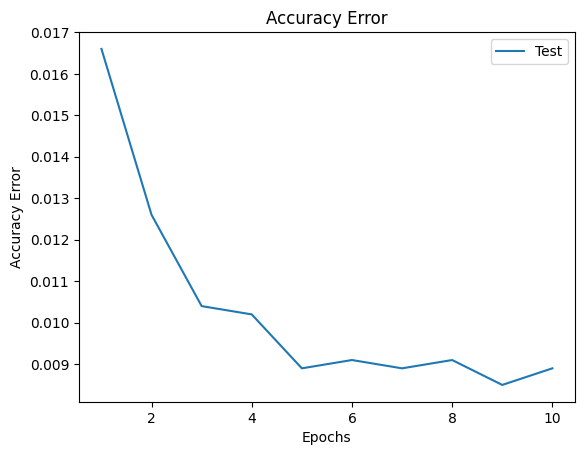

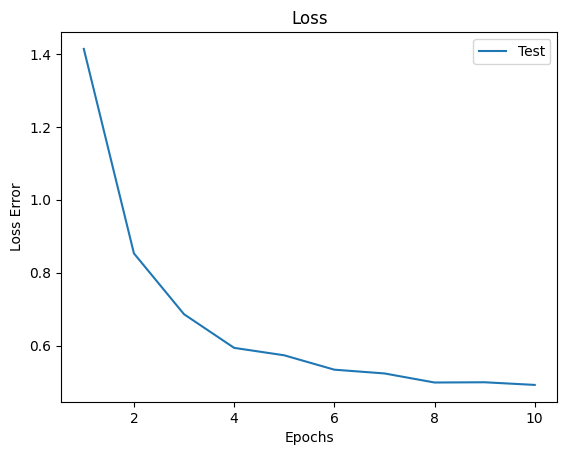

2-element Array{Any,1}:
 [0.016600000000000947, 0.012600000000000722, 0.010400000000000187, 0.010200000000000542, 0.008900000000000241, 0.009100000000000663, 0.008900000000000463, 0.009100000000000552, 0.008500000000000063, 0.008900000000000463]
 [1.4135549611598253, 0.8528865371085703, 0.6860578919481486, 0.593792011262849, 0.5733993075229228, 0.53397394109983, 0.5236578459036536, 0.49877882182830946, 0.4994433896325063, 0.4921695708320476]                      

In [67]:
if (print("Show results from scratch?(For showing results from scratch you should train from scratch first!) "); readline()[1]=='y')
  tst_err,tst_loss = calculate_loss_and_error(trained_weights,dtst,complete_network;numIter=number_of_iteration)
  trn_err,trn_loss = calculate_loss_and_error(trained_weights,dtrn,complete_network;numIter=number_of_iteration)
  all_results = show_results(trn_err,trn_loss,tst_err,tst_loss);
else
  results_file_name = getFileName(use_reconstruction_loss,number_of_iteration,"results",fromDrive = get_files_from_drive);
  all_results = Knet.load(results_file_name,"results");
  show_results(all_results); 
end

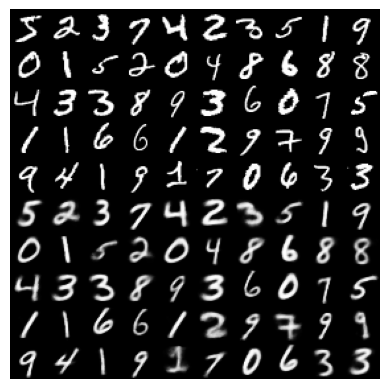

(-0.5, 279.5, 279.5, -0.5)

In [ ]:
## Comparison with original images and reconstructed images is only available when reconstruction is used as  regularization method
if use_reconstruction_loss
  x,y = first(dtrn);
  comparison_image_constructor(w_trained,x,complete_network);
end

Select an integer from 1 to 50stdin> 2


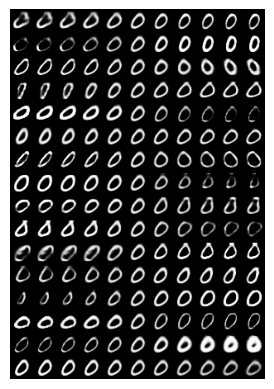

(-0.5, 307.5, 447.5, -0.5)

In [ ]:
## Comparison with original images and reconstructed images is only available when reconstruction is used as  regularization method
if use_reconstruction_loss
  print("Select an integer from 1 to 50"); 
  seq = readline();
  seq_no = parse(Int64, seq)
  x,y = first(dtrn);
  same_image_change_with_digitcaps_reconstructor(w_trained,x, complete_network,seq_no;numIter = 3)
end